# Text analysis workbook



[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MNoichl/OZSW2025-data-driven-philosophy/blob/main/workbook_01_text_analysis.ipynb) 

Welcome to google colab! Colab is a cloud-based notebook environment that allows you to write and execute code in the python programming language in the browser. It follows a notebook structure (like jupyter) in which you can write markdown text like this, as well as code in cells that can be executed.

Below is one of these cells. You can run it either by clicking the little (▶️) button on the top left of the cell, or by clicking into it and then pressing shift+enter:


In [ ]:
print("Hello World")


If you want to continue working on this notebook, and make your own changes to the code, we'd reccomend you save your own copy, by clicking the "File" menu at the top left, and then "Save a copy in Drive". Please do this as it's easy to loose your work otherwise. You can then edit your own copy. You can also download it as an .ipynb file by clicking the "File" menu at the top left, "Download", and then "Download .ipynb". If you want to learn more about the functionalites of colab notebooks, we reccommend looking at this [basic colab features-notebook.](https://colab.research.google.com/notebooks/basic_features_overview.ipynb)

** Important:** Below we are going to run a LLM. This needs a more powerful computer, called an GPU. You can select this by doing Runtime -> Change Runtime Type -> T4 GPU.

# Part 1: Set-up
At the beginning of this notebook, we need to set up all of the libraries/packages (reusable python-programs other people have written) that we are going to use during this session. For this we use a common python-package manager called 'pip'. Pip takes care of downloading the right versions, and installing them on our computer, which in this case is a server that's standing in a google-data-center, maybe in Belgium or Iowa. These installs will take a minute or two.

In [ ]:
%%capture

!pip install pandas
!pip install pyalex
!pip install umap-learn
!pip install datamapplot
!pip install upgrade sentence-transformers 
!pip install seaborn
!pip install genieclust
!pip install litellm
!pip install opinionated
!pip install keybert
!pip install keyphrase-vectorizers
!pip install pystreamgraph

!pip install -q --upgrade "transformers>=4.45.2" "sentence-transformers>=3.0.1"
!pip install --upgrade 'nltk==3.8.1' 

!python3 -m spacy download en_core_web_sm # for English NER



#%pip install -q --upgrade "transformers==4.44.2" "sentence-transformers==2.7.0" "accelerate>=0.33" "keybert>=0.8.5" "torch>=2.2,<2.5"



# Check if utils directory exists, if not download from GitHub
import os
if not os.path.exists('utils'):
    !wget -q https://raw.githubusercontent.com/MNoichl/data-driven-philosophy-GAP2025/main/utils/openalex_utils.py -P utils/
    !wget -q https://raw.githubusercontent.com/MNoichl/data-driven-philosophy-GAP2025/main/utils/streamgraph.py -P utils/
  
  
  
  



# Part 2: Imports

After setting up the packages, we need to import them. This makes the code in the packages available for us to use later. 

In [ ]:
# Enable autoreload for development
# %load_ext autoreload
# %autoreload 2

# Core data science libraries
import pandas as pd  # Data manipulation and analysis
import numpy as np   # Numerical computing and arrays
import os           # Operating system interface

# Visualization libraries
import matplotlib.pyplot as plt  # Basic plotting functionality
import seaborn as sns           # Statistical data visualization
from matplotlib.colors import rgb2hex

# Academic data access
import pyalex  # Interface to OpenAlex academic database

# Dimensionality reduction and clustering
import umap         # Uniform Manifold Approximation and Projection
import datamapplot  # Interactive visualization for high-dimensional data

# Natural language processing and AI
import sentence_transformers  # Sentence embeddings using transformer models
import litellm                # Unified interface for various LLM APIs
import spacy


# Styling and aesthetics
import opinionated  # Opinionated matplotlib styling
plt.style.use('opinionated_rc')
import colormaps as colormaps  # Extended colormap collection - https://pratiman-91.github.io/colormaps/

# progress bar
from tqdm import tqdm



from utils.openalex_utils import openalex_url_to_pyalex_query, process_records_to_df, get_records_from_dois, openalex_url_to_filename, download_openalex_records

# Part 3: Getting data

In this notebook we are interested in analysing textual data. For this we have prepared a dataset of texts from the *Stanford Encyclopedia of Philosophy*. Alternatively, we have set up code that allows you to quickly scrape your own dataset of abstracts from the *OpenAlex*-database. Finally, if you have your owns data-source to work with, we can show you how to hook it up to this notebook below. **Important:** You will only want to run one of the three sub-sections below. 

# Part 3.1 Stanford-Encyclopedia dataset

The code below downloads a zip-file of SEP-articles, and loads the texts into memory as a list, text_data.

In [ ]:
import requests
import zipfile
from pathlib import Path

# Download and extract if needed
stanford_zip = Path("stanford-encyclopedia.zip")
stanford_folder = Path("stanford-encyclopedia")
if not stanford_folder.exists():
    zip_data = requests.get("https://github.com/MNoichl/OZSW2025-data-driven-philosophy/raw/refs/heads/main/files/stanford-encyclopedia.zip").content
    with zipfile.ZipFile(zipfile.io.BytesIO(zip_data)) as zip_ref:
        zip_ref.extractall(".")

# Load data
text_data = [open(f, encoding='utf-8').read() for f in stanford_folder.glob("*.txt") if f.suffix in ['.txt', '.md']]
title_data = [f.stem for f in stanford_folder.glob("*") if f.suffix in ['.txt', '.md']]
# Extract year data from copyright strings in the text files
import re

year_data = []
for text in text_data:
    # Look for "Copyright © YYYY" pattern at the beginning of the text
    match = re.search(r'Copyright © (\d{4})', text)  
    if match:
        year_data.append(int(match.group(1)))
    else:
        year_data.append(None)  # If no copyright year found

used_dataset = "Stanford Encyclopedia"

print(len(text_data), len(title_data), len(year_data))

## Part 3.2 OpenAlex-datasets.

We have written a function that takes in an arbitrary url to a OpenAlex search query, and downloads the abstracts associated with it. To use it, head over to [https://openalex.org](https://openalex.org), search for something you are interested in, and copy the web-address of your search address. Then replace the url behind ` openalex_url = `  with the new one. Make sure to keep the quotation marks around it. That tells python that this is a string of text, and not executable python code. 

In [ ]:
openalex_url = 'https://openalex.org/works?page=1&filter=primary_location.source.id:s255146,publication_year:2005-2025'

dataset_df = download_openalex_records(openalex_url,
                                       reduce_sample=True, 
                                       sample_reduction_method="n random samples", 
                                       sample_size=1000, 
                                       seed_value="42")


dataset_df['text'] = dataset_df['title'] + dataset_df['abstract'] 
# We filter for works that have an abstract:
dataset_df = dataset_df[dataset_df['text'].str.len() > 10]

text_data = list(dataset_df['text'])
year_data = dataset_df['publication_year']
title_data = dataset_df['title']

used_dataset = "OpenAlex-query"






# 3.3 Bring your own data

Below you can hook up your own dataset. The remainder of the notebook expects `text_data`and  `title_data`to be lists of strings, and  `year_data`to be a list of numbers.


In [ ]:
text_data = "..."
title_data = "..."
year_data = "..."

used_dataset = "NAME YOUR DATASET HERE"

# Part 4: Named Entity Recognition (NER)

Named entity recognition is a branch of natural language processing (NLP). Within an NLP pipeline, it is a relatively late step:

<center><img src='./files/NER_NLP_pipeline.png' width=700></center>

This is because it needs to receive a tokenized text and, in some languages, it needs to understand a word's part-of-speech (POS) to perform well. To determine whether a particular part of a text is a name, our model relies on a tokenization (splitting) of the text and its tagging for a particular part of speech (noun, verb, etc.). 

*(Graphic from William Mattingly, CC-BY, 2022 Text Analysis Pedagogy Institute)*

In [ ]:
nlp = spacy.load("en_core_web_sm")

Tokenization distinguishes full stops that end sentences from those that occur in abbreviations and initials (like G. E. Moore) - simply splitting by `.` would not give the right result.

In [ ]:
text = "G.E. Moore is known as a good writer. Perhaps he is also good at programming?"

We can run the basic spacy pipeline on our text object like so:

In [ ]:
doc = nlp(text)

The resulting doc object is structured. We can inspect its sentences:

In [ ]:
list(doc.sents)

The spacy nlp pipeline also extracts a list of entities. Each entity has a text attribube (from the text source) and a label attribute, which we can inspect:

In [ ]:
[(ent.text, ent.label_) for ent in doc.ents]

This processing of the raw text into a doc object follows a number of steps that we can inspect (and adapt). 

In [ ]:
nlp.pipe_names

## Looking at the Stanford Encyclopedia

Instead of looking at a toy sentence, we can process articles from the Stanford Encyclopedia. Here for a single (arbitrary) article:

In [ ]:
doc = nlp(text_data[42])

The NER will now try to detect (and distinguish) persons, organizations, etc. If we only look at the entities tagged as persons:

In [ ]:
[(ent.text, ent.label_) for ent in doc.ents if ent.label_=='PERSON'][0:20]

In [ ]:
print(f'We find {len([ent for ent in doc.ents if ent.label_=="PERSON"])} person labelled entities')

We can summarize this with a Counter object:

In [ ]:
from collections import Counter
count = Counter()
count.update([ent.text for ent in doc.ents if ent.label_=='PERSON'])
count.most_common(10)

And clean some of the labels by removing the year-strings - this is also important to sum over variants.

In [ ]:
def strip_years(text):
    """
    Clean years and punctuation from labels.
    """
    return re.sub("\s?[0-9]|['|.)(]",'', text)

strip_years("Kant's new add")

In [ ]:
count = Counter()
count.update([strip_years(ent.text) for ent in doc.ents if ent.label_=='PERSON'])
count.most_common(10)

But have all person names been understood correctly? let's look at the Organizations.

In [ ]:
count = Counter()
count.update([strip_years(ent.text) for ent in doc.ents if ent.label_=='ORG'])
count.most_common(10)

A lot of these organization tags are actually referring to people - unsurprising, since many organizations are named after people. So we should expect some errors when trying to distinguish these automatically. 

In our specific case, we have background knowledge - we expect people to be mentioned much more than companies or organizations. And we know that many of these names are philosophers that should be tagged as persons. To take this into account, we can add an extra step in the NER pipeline.

## Adding an entity ruler

We can add explicit rules for detecting entities with an 'entity ruler'. This acts as an additional step in the spaCy pipeline.

In [ ]:
names = ['Stoljar', 'Benson', 'Kymlicka'] # These can be many, feel free to add your own...
patterns = [{"label":"PERSON", "pattern":name} for name in names]

In [ ]:
nlp.pipe_names

In [ ]:
nlp2 = spacy.load("en_core_web_sm", exclude=["tagger","parser","lemmatizer","attribute_ruler"])

In [ ]:
entruler = spacy.blank('en') # Create a blank English model
nlp_rules = nlp2.add_pipe("entity_ruler", before='ner') # specify that the EntityRuler comes before built-in NER
nlp_rules.add_patterns(patterns)

In [ ]:
nlp2.pipe_names

The entity ruler now tags the patterns we have defined as persons, before we run the standard NER component. 

In [ ]:
doc2 = nlp2(text_data[42])

In [ ]:
count2 = Counter()
count2.update([strip_years(ent.text) for ent in doc2.ents if ent.label_=='PERSON'])
count2.most_common(10)

Compare again with the top names without our entity ruler:

In [ ]:
doc = nlp(text_data[42])
count = Counter()
count.update([strip_years(ent.text) for ent in doc.ents if ent.label_=='PERSON'])
count.most_common(10)

Now the explicitly mentioned names are taken into account. Of course, in the raw text there are many more phrases and words that we might want to include as mentions of e.g. Kant:

In [ ]:
c = Counter()
c.update([strip_years(word) for word in text_data[42].split(' ') if re.match('Kant', word)])

In [ ]:
print(c)

Is 'Kant' mentioned when Korsgaard is described as a Kantian? Even simple counting needs to answer some conceptual questions.

## Running on the full corpus
(not efficient, can take a while...) Here we are only taking the first 10

In [ ]:
from tqdm import tqdm
import os

# Sample n random documents if desired
import random

sampled_texts = random.sample(text_data, 100)


docs = list(
    tqdm(
        nlp2.pipe(sampled_texts, batch_size=1, n_process=max(os.cpu_count()-1, 1)),
        total=len(sampled_texts),
        unit="doc",
        mininterval=0.2
    ))

In [ ]:
corpcount = Counter()
for doc in docs:
    corpcount.update([strip_years(ent.text) for ent in doc.ents if ent.label_=='PERSON'])

In [ ]:
print(corpcount.most_common()[0:10])

In [ ]:
import matplotlib.pyplot as plt

# Get top 20 most common names
top_20 = corpcount.most_common(20)
names = [item[0] for item in top_20]
counts = [item[1] for item in top_20]

# Create horizontal bar chart
plt.figure(figsize=(10, 8))
plt.barh(names, counts, color='#980f0e')
plt.xlabel('Count')
plt.ylabel('Names')
plt.title('Top 20 Most Mentioned Philosophers/Thinkers')
plt.gca().invert_yaxis()  # To show highest count at top
plt.tight_layout()
plt.show()


# Part 4B: Finding names with an LLM pipeline
Here we are testing a different technique on the same problem - by running a NER pipeline from huggingface.
Huggingface makes a large number of LLMs and complete pipelines for particular tasks available with a convenient interface. We now use a default NER pipeline to compare it with the spacy baseline. When not sure which method to choose, it can be easiest to just try several candidates and compare the results.

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

modelname = "dslim/bert-base-NER"

# To feed our text into suitable chunks to our pipeline, we need a tokenizer.
# Different model classes expect different tokenizations.
# The AutoTokenizer class selects a suitable tokenizer based on the model we are using.
tokenizer = AutoTokenizer.from_pretrained(modelname)
model = AutoModelForTokenClassification.from_pretrained(modelname)

# When running these commands, you download the models from the hugging face hub.
# This can also yield some warnings since we are using a model that was customized
# for the NER task.


Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
nlp = pipeline("ner", model=model,
               tokenizer=tokenizer,
               # tokens can be smaller than words, so we need to guess how to group them together.
               aggregation_strategy='max')
text = "G.E. Moore is known as a good writer. Perhaps he is also good at programming? Quine certainly would be."


ner_results = nlp(text)
import pprint # for nicer printing of dictionaries
pprint.pprint(ner_results)

Device set to use cuda:0


[{'end': 1,
  'entity_group': 'PER',
  'score': np.float32(0.99962187),
  'start': 0,
  'word': 'G'},
 {'end': 3,
  'entity_group': 'PER',
  'score': np.float32(0.84697735),
  'start': 1,
  'word': '. E'},
 {'end': 10,
  'entity_group': 'PER',
  'score': np.float32(0.8582274),
  'start': 3,
  'word': '. Moore'},
 {'end': 83,
  'entity_group': 'PER',
  'score': np.float32(0.99589086),
  'start': 78,
  'word': 'Quine'}]


The output format is quite different - we have different labels for the entity types and we have scores. The different aggregation strategies - 'None', 'simple', 'first', 'average', 'max' give different results, especially for entities that stretch over several tokens.

In [ ]:
def extract_names(ner_results):
    """
    Return a list of the (fused) tokens that are classified as 'PER'.
    """
    names = [result['word'] for result in ner_results if result['entity_group'] == 'PER']
    return names


extract_names(ner_results)

['G', '. E', '. Moore', 'Quine']

Now we can run the pipeline on the same SEP article as before.

In [ ]:
ner_results = nlp(text_data[11])
extract_names(ner_results)

['S', 'S', 'S', 'Malcolm']

Why does this not work? Because we cannot process the entire text at once! We need to break it into smaller chunks, such as sentences.

In [ ]:
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
sentences = sent_tokenize(text_data[11])
ner_results = nlp(sentences)
names_per_sentence = [extract_names(result) for result in ner_results]
# This gives us a list of lists:
names_per_sentence[25:35]

[[],
 ['Goldman'],
 ['Richard Rorty', 'David Annis'],
 [],
 ['Annis'],
 ['Annis'],
 ['Annis'],
 ['Gettier'],
 ['John Pollock', 'Harman', 'Sosa'],
 []]

In [ ]:
# Now we count them
count = Counter()
for sentencelist in names_per_sentence:
    count.update(sentencelist)
count.most_common(10)

[('Cohen', 30),
 ('DeRose', 27),
 ('Lewis', 24),
 ('S', 18),
 ('Rysiew', 11),
 ('Craig', 11),
 ('Hawthorne', 10),
 ('John', 9),
 ('Smith', 9),
 ('Mary', 8)]

# Part 5: Using a language model 
We are now going to use a text-embedding model (a relatively small large language model) to transform the texts into a format which is easier to analyze mathematically.  The most famous of these models is called BERT (Bidirectional encoder representations from transformers), but there are many models you can choose from for this purpose. Look around e. g. here: [https://www.sbert.net/docs/sentence_transformer/pretrained_models.html ](https://www.sbert.net/docs/sentence_transformer/pretrained_models.html )

While they are trained on different datasets and can have a variety of different architectures, their main principles are very similar: Sub-word-particles, called tokens, are associated with long strings of numbers, called embeddings. These embeddings learned during the training-process. When presented with new texts, as we are going to do below, the model cuts the text up into the tokens, and selects the associated embeddings. The embeddings then undergo a process called 'attention' in which the individual representations interact with, and change each-other. In this process, the model adapts the individual embeddings to their context, and changes e.g. the embeddings associated with 'bank', depending on whether the word is close to 'river', as opposed to 'deposit'. Finally, the embeddings of all the tokens in the text get summarized, e.g. by averaging thm. This final embedding, whihc contains information from all the tokens then gets used to represent the whole text.



In [ ]:
from sentence_transformers import SentenceTransformer

model_name = "all-mpnet-base-v2" # "answerdotai/ModernBERT-base",  "Qwen/Qwen3-Embedding-0.6B"
model = SentenceTransformer(model_name) #thenlper/gte-small
embeddings = model.encode([x[:3000] for x in text_data],
                          show_progress_bar=True)


This is what the resulting embeddings look like - each row represents one of our texts:


In [ ]:
print(embeddings)

# Part 6: applying dimensionality reduction


The attractive thing about text embeddings is that we can calculate similarities between them, which will, due the way that the embedding model is trained, reflect the how similar the topics of the texts are. One way of analyzing these similarities is by using UMAP (Uniform Manifold approximation and Projection). What UMAP effectively does is compute a nearest-neighbour graph, in which each text is linked to the other texts that are most similar to it, reweigh the graph so that high density areas don't dominate, and then layout the resulting network in a lower dimensional space using a force based simulation, in which linked nodes are pulled together, while unconnected nodes are pushed apart. This reproduces important features of outr dataset, whoch originally where encoded in several hundred dimensions in two. For an intuitive explanation to umap, see: [https://pair-code.github.io/understanding-umap/](https://pair-code.github.io/understanding-umap/). Below we produce a layout in two dimensions:

In [ ]:
import umap


reducer = umap.UMAP(n_components=2, random_state=42,metric='cosine')
umap_embeddings = reducer.fit_transform(embeddings)

print(umap_embeddings)


We can also look at the embeddings as a scatter-plot. Each data-point is one of our texts. Note that while the below looks like a scatter plot, the x- and y-axes hold no information. The plot is rotation-invariant, and only the distances between the datapoints are relevant. 

In [ ]:
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1],alpha=0.1, c='black')
plt.axis('equal')
plt.show()

# Part 7: Clustering 

To get a better idea of what the the different areas of the plot mean, we can employ clustering. Because the 2-d umap looses a lot of information (768 Dimensions just don't fit that well into 2), and most clustering-algorithms struggle with high dimensional data due to the so-caled *curse of dimensionality*, we run another UMAP-reduction to 30 dimensions, on which we cluster. Here we employ genieclust, a flexible version of agglomerative clustering([https://genieclust.gagolewski.com/weave/basics.html](https://genieclust.gagolewski.com/weave/basics.html)), that allows us to tune how imbalanced we allow cluster sizes to be.

In [ ]:
import genieclust

reducer = umap.UMAP(n_components=30, random_state=42,metric='cosine')
umap_embeddings_high_dim = reducer.fit_transform(embeddings)

g = genieclust.Genie(n_clusters=15, gini_threshold=0.3)
cluster_labels = g.fit_predict(umap_embeddings_high_dim)
print(cluster_labels[0:20])

We now create a dictionary of colors, which we can use in all the later plots:

In [ ]:
# Get unique cluster labels
unique_clusters = np.unique(cluster_labels)
n_clusters = len(unique_clusters)

# Get colors from antique colormap, repeating if necessary
antique_colors = colormaps.antique(np.linspace(0, 1, colormaps.antique.N))
repeated_colors = np.tile(antique_colors, (n_clusters // colormaps.antique.N + 1, 1))[:n_clusters]

custom_color_map = dict(
    zip(
        unique_clusters,
        map(rgb2hex, repeated_colors)
    )
)

And then we plot the umap from above with the clusters overlayed on top:

In [ ]:
plt.scatter(x=umap_embeddings[:, 0], 
            y=umap_embeddings[:, 1],
            c=[custom_color_map[x] for x in cluster_labels],
            alpha=0.8)

# Part 8: Labeling clusters

We now want to find out what our clusters actually contain. One quick, and a little drity way to do this is to simpy show examples from each cluster to an LLM, and have it come up with a name for it. As we are using a strong LLM here via an API, we need to add an API-key in place of the "..." below. API keys are secrets that are directly connected to our credit-cards, so we have to treat them carefully! We are going to send the key for this workshop out via E-Mail.

In [ ]:
API_KEY = "..."


if API_KEY == "...": # This code below is only for local development. You can ignore it!
    with open('API_KEYS.txt', 'r') as file:
        for line in file:
            if line.startswith('OPENAI:'):
                API_KEY = line.split(':', 1)[1].strip()
                break
        else:
            raise ValueError("OPENAI API key not found in API_KEYS.txt")

os.environ["OPENAI_API_KEY"] = API_KEY

Now we can  create our labels. The `label_cluster`function takes in a list of text from each cluster, takes a random sample, and, using the prompt, asks the LLM to name them. Feel free to play with the prompt to steer the labels into the right direction. 

In [ ]:
from litellm import completion
import pandas as pd
import random
import json

# Create a function to label clusters using OpenAI
def label_cluster(cluster_texts, cluster_id, n_samples=10, extra_prompt=""):
    # Randomly sample representative texts from the cluster (max 10 for efficiency)
    sample_size = min(10, len(cluster_texts))
    sample_texts = random.sample(cluster_texts, sample_size)
    
    # Truncate texts to 100 characters
    sample_texts = [text[:1000] + "..." if len(text) > 1000 else text for text in sample_texts]
    
    prompt = f"""
    Below are randomly sampled texts from cluster {cluster_id}. Please analyze these texts and provide:
    1. A short descriptive label (2-4 words). 
    2. A brief description of the main theme.
    {extra_prompt}

    Texts:
    {chr(10).join([f"- {text[:200]}..." if len(text) > 200 else f"- {text}" for text in sample_texts])}
    
    Please respond in JSON format:
    {{
        "label": "[your label]",
        "description": "[your description]"
    }}
    """
    
    messages = [{"content": prompt, "role": "user"}]
    response = completion(model="openai/gpt-5", messages=messages, response_format={"type": "json_object"})
    return response.choices[0].message.content

# Group texts by cluster
cluster_groups = {}
for i, label in enumerate(cluster_labels):
    if label not in cluster_groups:
        cluster_groups[label] = []
    cluster_groups[label].append(text_data[i])

# Label each cluster
cluster_info = {}
for cluster_id, texts in cluster_groups.items():
    print(f"Labeling cluster {cluster_id} ({len(texts)} texts)...")
    label_info = label_cluster(texts, cluster_id, n_samples=5, extra_prompt="Note that the clusters are areas of philosophy that the texts are from. Try to pick labels that are commonly used to describe areas of philosophy.")
    cluster_info[cluster_id] = label_info
    print(f"Cluster {cluster_id}: {label_info}\n")

# Create a summary dataframe
cluster_summary = []
for cluster_id, info in cluster_info.items():
    # Parse the JSON response
    try:
        parsed_info = json.loads(info)
        label = parsed_info.get('label', 'Unknown')
        description = parsed_info.get('description', 'No description available')
    except (json.JSONDecodeError, TypeError):
        # Fallback if JSON parsing fails
        label = f"Cluster {cluster_id}"
        description = str(info)
    
    cluster_summary.append({
        'Cluster_ID': cluster_id,
        'Size': len(cluster_groups[cluster_id]),
        'Label': label,
        'Description': description
    })

cluster_df = pd.DataFrame(cluster_summary)
cluster_df

We also do some data-wrangling, to have one long list of labels for each data-point, and to update our label-dictionary:

In [ ]:
# Create a labels list from cluster_labels and the labeled cluster descriptions
labels_list = []
for cluster_id in cluster_labels:
    # Find the corresponding label from the cluster_df
    cluster_row = cluster_df[cluster_df['Cluster_ID'] == cluster_id]
    label = cluster_row.iloc[0]['Label']
    labels_list.append(label)

# Update the custom_color_map to use cluster labels instead of cluster IDs
custom_color_map = {}
for cluster_id in unique_clusters:
    # Find the corresponding label from the cluster_df
    cluster_row = cluster_df[cluster_df['Cluster_ID'] == cluster_id]
    label = cluster_row.iloc[0]['Label']
    
    # Get the color for this cluster_id from the original mapping
    color_index = list(unique_clusters).index(cluster_id)
    color = rgb2hex(repeated_colors[color_index])
    custom_color_map[label] = color




# Part 9: Visualizing

## 9.1 An interactive data-map

To bring everything we've done so far together, we produce an interactive map of our datast. This includes the umap, the clusters and the labels. On hovering over the datapoints we can see their titles. This allows us to explore the structure of our dataset, as well investigate properties, and potential failures of our data and pipeline. 

In [ ]:
import datamapplot

datamapplot.create_interactive_plot(
    umap_embeddings,
    labels_list,  
    hover_text=[x.title() for x in title_data],  
    label_color_map=custom_color_map,
    title=used_dataset
)

## 9.2 Historical developments

One common application of topic-modelling/clustering is to investigate the historical development of a corpus. An easy way to accomplish this is a stream-graph, in which the size of each cluster changes as a function of time. We first have to do some data-wrangling:

In [ ]:
# Prepare data for streamgraph visualization
# Convert the year_data and clusters into the format expected by plot_streamgraph

# Get unique years and sort them
years_sorted = sorted(set(year_data))
X_stream = np.array(years_sorted)

# Get unique clusters and their labels
unique_clusters = sorted(set(cluster_labels))
cluster_labels_to_plot = []
for cluster_id in unique_clusters:
    if cluster_id in cluster_df['Cluster_ID'].values:
        label = cluster_df[cluster_df['Cluster_ID'] == cluster_id]['Label'].iloc[0]
        cluster_labels_to_plot.append(label)
    else:
        cluster_labels_to_plot.append(f"Cluster {cluster_id}")

# Create Y matrix: each row is a cluster's values over time
Y_stream = []
for cluster_id in unique_clusters:
    cluster_values = []
    for year in years_sorted:
        # Count documents in this cluster for this year
        cluster_count = sum(1 for i, (doc_year, doc_cluster) in enumerate(zip(year_data, cluster_labels)) 
                           if doc_year == year and doc_cluster == cluster_id)
        cluster_values.append(cluster_count)
    Y_stream.append(cluster_values)

Y_stream = np.array(Y_stream)

print(f"Streamgraph data prepared:")
print(f"X (years): {len(X_stream)} points from {X_stream[0]} to {X_stream[-1]}")
print(f"Y (clusters): {Y_stream.shape[0]} clusters × {Y_stream.shape[1]} time points")
print(f"Cluster labels: {cluster_labels_to_plot[:3]}...")  # Show first 3 labels


There is no good streamgraph-library in python that we know of, so we made our own and import it here. This version can sort the clusters by size over time, showing which clusters grow and fade proportionally, as well as the growth of the corpus as a whole in absolute numbers.

In [ ]:
from pystreamgraph import plot_streamgraph, order_bestfirst, order_twoopt


order = order_twoopt(X_stream[7:], Y_stream[:,7:], repeats=12, scans=4)


fig, ax = plt.subplots(figsize=(10, 8))

plot_streamgraph(X_stream[7:], 
                 Y_stream[:,7:], 
                labels=cluster_labels_to_plot,
                cmap=custom_color_map,
                wiggle_reduction="weighted",
                sorted_streams=False,  # Keep original stream order
                label_position='end',  # Use annealed placement to avoid overlaps
                curve_samples=24,  # Smooth curve interpolation
                label_fontsize_min=8,  # Minimum font size for smaller streams
                label_fontsize_max=14,  # Maximum font size for larger streams
                label_color='black',
                label_edge_offset_frac=0.005,
                label_anchor='middle_center',
                ax=ax,
                )

plt.title("Streamgraph of the {} over time".format(used_dataset))
plt.gca().yaxis.set_visible(False)

# Getting embeddings for specific words

Instead of embedding the whole texts, we can also compute embeddings for individual tokens, or token-sequences. This allows us to trace the semantics of individual words, at least in so far as they are determined by their contexts (as understood by the llm).
The two codeblocks first extract all the contexts of a keyphrase, and then extract the representations corresponding to the key-phrase from the embedding of the whole context.

In [ ]:
key_phrase = "epistemic "

def extract_context_around_phrase(text_data, key_phrase, sentences_before=2, sentences_after=2):
    """
    Extract text chunks around occurrences of a key phrase, including surrounding sentences.
    
    Parameters:
    - text_data: list of strings or single string containing the text(s) to search
    - key_phrase: string to search for
    - sentences_before: number of sentences to include before the key phrase
    - sentences_after: number of sentences to include after the key phrase
    
    Returns:
    - list of dictionaries with 'text', 'doc_index', and 'phrase_position' keys
    """
    import re
    
    # Ensure text_data is a list
    if isinstance(text_data, str):
        text_data = [text_data]
    
    contexts = []
    
    for doc_idx, text in enumerate(text_data):
        # Split text into sentences (simple approach using periods, exclamation marks, question marks)
        sentences = re.split(r'[.!?]+', text)
        sentences = [s.strip() for s in sentences if s.strip()]  # Remove empty sentences
        
        # Find sentences containing the key phrase
        for sent_idx, sentence in enumerate(sentences):
            if key_phrase.lower() in sentence.lower():
                # Calculate context window
                start_idx = max(0, sent_idx - sentences_before)
                end_idx = min(len(sentences), sent_idx + sentences_after + 1)
                
                # Extract context sentences
                context_sentences = sentences[start_idx:end_idx]
                context_text = '. '.join(context_sentences)
                
                # Add period at the end if not present
                if not context_text.endswith(('.', '!', '?')):
                    context_text += '.'
                
                contexts.append({
                    'text': context_text,
                    'doc_index': doc_idx,
                    'phrase_position': sent_idx,
                    'sentence_range': (start_idx, end_idx-1)
                })
    
    return contexts

# Extract contexts around the key phrase
contexts = extract_context_around_phrase(text_data, key_phrase, sentences_before=2, sentences_after=2)
context_texts = [context['text'] for context in contexts]

# Let's also add the years to the contexts, for later:
for x in contexts:
    x['year'] = year_data[x['doc_index']]



We can check what this looks like:

In [ ]:

contexts[0:3]

Now we extract the embeddings for the key-phrase. This is a bit more work then above:

In [ ]:
from sentence_transformers import SentenceTransformer
import torch

def phrase_vectors(key_phrase, texts, model_name="sentence-transformers/all-MiniLM-L6-v2"):
    model = SentenceTransformer(model_name)
    tok = model._first_module().tokenizer
    needle = key_phrase.lower()
    out = []

    for text in tqdm(texts):
        enc = tok(text, return_offsets_mapping=True, return_tensors="pt")
        offsets = enc["offset_mapping"][0].tolist()  # (start_char, end_char) per token

        with torch.no_grad():
            token_embs = model.encode(text, output_value="token_embeddings", convert_to_tensor=True, show_progress_bar=False)
            # This is a bit inefficient, because we are not batching, but should be fine for most cases.

        spans, i, hay = [], 0, text.lower() # Problematic for multiple KP's per chunk?
        while True:
            i = hay.find(needle, i)
            if i == -1: break
            spans.append((i, i + len(needle)))
            i += 1

        idxs = [t for t,(a,b) in enumerate(offsets)
                if b > 0 and any(not (b <= s or a >= e) for s,e in spans)]

        out.append(token_embs[idxs].mean(0).cpu() if idxs else None)

    return out

key_phrase_embeddings = np.array(phrase_vectors(key_phrase, context_texts, model_name="answerdotai/ModernBERT-base"))


We can again use umap for low dimensional, explorable embeddings, and genieclust to cluster. As we expect there to be one, or a few dominant meanings, we choose a higher target-genie-coeffiecient here (but ymmv).

In [243]:
import umap


key_phrase_reducer = umap.UMAP(n_components=2, random_state=42,metric='cosine')
key_phrase_umap_embeddings = key_phrase_reducer.fit_transform(key_phrase_embeddings)

print(key_phrase_umap_embeddings)


/Users/Noich001/Desktop/OZSW2025-data-driven-philosophy/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


KeyboardInterrupt: 

In [ ]:
import genieclust

key_phrase_high_dim_reducer = umap.UMAP(n_components=30, random_state=42,metric='cosine')
key_phrase_high_dim_umap_embeddings = key_phrase_high_dim_reducer.fit_transform(key_phrase_embeddings)

g = genieclust.Genie(n_clusters=10, gini_threshold=0.4)
concept_cluster_labels = g.fit_predict(key_phrase_high_dim_umap_embeddings)


n_clusters = len(np.unique(concept_cluster_labels))
cb_colors = colormaps.tealrose(np.linspace(0, 1, colormaps.tealrose.N))
repeated_concept_colors = np.tile(cb_colors, (n_clusters // colormaps.tealrose.N + 1, 1))[:n_clusters]

custom_concept_color_map = dict(zip(np.unique(concept_cluster_labels),map(rgb2hex, repeated_concept_colors)))

plt.scatter(key_phrase_umap_embeddings[:, 0], key_phrase_umap_embeddings[:, 1],alpha=0.1, c=[custom_concept_color_map[x] for x in concept_cluster_labels])
plt.axis('equal')
plt.show()

We can also reuse the labeling code from above:

In [ ]:
# Group texts by concept cluster
concept_cluster_groups = {}
for i, label in enumerate(concept_cluster_labels):
    if label not in concept_cluster_groups:
        concept_cluster_groups[label] = []
    concept_cluster_groups[label].append(contexts[i]['text'])

# Label each concept cluster
concept_cluster_info = {}
for cluster_id, texts in concept_cluster_groups.items():
    print(f"Labeling concept cluster {cluster_id} ({len(texts)} texts)...")
    label_info = label_cluster(texts, cluster_id, n_samples=5, extra_prompt=f"Note that these are clusters of text contexts containing the key phrase '{key_phrase}'. Try to pick labels that describe the different conceptual uses or meanings of this phrase.")
    concept_cluster_info[cluster_id] = label_info
    print(f"Concept cluster {cluster_id}: {label_info}\n")

# Create a summary dataframe
concept_cluster_summary = []
for cluster_id, info in concept_cluster_info.items():
    # Parse the JSON response
    try:
        parsed_info = json.loads(info)
        label = parsed_info.get('label', 'Unknown')
        description = parsed_info.get('description', 'No description available')
    except (json.JSONDecodeError, TypeError):
        # Fallback if JSON parsing fails
        label = f"Concept Cluster {cluster_id}"
        description = str(info)
    
    concept_cluster_summary.append({
        'Cluster_ID': cluster_id,
        'Size': len(concept_cluster_groups[cluster_id]),
        'Label': label,
        'Description': description
    })

concept_cluster_df = pd.DataFrame(concept_cluster_summary)
concept_cluster_df

In [ ]:
# Create a labels list from concept_cluster_labels and the labeled concept cluster descriptions
concept_labels_list = []
for cluster_id in concept_cluster_labels:
    # Find the corresponding label from the concept_cluster_df
    cluster_row = concept_cluster_df[concept_cluster_df['Cluster_ID'] == cluster_id]
    label = cluster_row.iloc[0]['Label']
    concept_labels_list.append(label)

# Update the custom_color_map to use concept cluster labels instead of cluster IDs
concept_custom_color_map = {}
unique_concept_clusters = sorted(set(concept_cluster_labels))
for cluster_id in unique_concept_clusters:
    # Find the corresponding label from the concept_cluster_df
    cluster_row = concept_cluster_df[concept_cluster_df['Cluster_ID'] == cluster_id]
    label = cluster_row.iloc[0]['Label']
    
    # Get the color for this cluster_id from the original mapping
    color_index = list(unique_concept_clusters).index(cluster_id)
    color = rgb2hex(repeated_concept_colors[color_index])
    concept_custom_color_map[label] = color


And build an interactive map of the meanings of our concept:

In [ ]:
import datamapplot

datamapplot.create_interactive_plot(
    key_phrase_umap_embeddings,concept_labels_list,
    hover_text=[text.replace(key_phrase, f" █{key_phrase}█ ") for text in context_texts],  
    label_color_map=concept_custom_color_map,
    title=f"{used_dataset} - {key_phrase}"
)

We can also, inspired by Zichert, Simons and Wüthrich (2025) analyze how the coherence of the concept changes over time. To do so, we compute for every year the "normalized Shannon Entropy", which for  us serves as a measure of uncertainty over clusters, or in other words: If I tell you the cluster distribution of a year, how hard is it to guess for you, in what sense a given word is going to be used. If only one cluster occurs, it's extremely easy, the entropy is zero. As more clusters appear, and the probability mass is spread out across them, it becomes harder, entropy increases. To get uncertainty estimates, we add a small 'extra-probability' to all clusters (which allows clusters with zero-counts to theoretically occur in our model, a weak prior), and then draw 4000 random samples from the resulting distributions (bootstrapping). Note that for low-data-density areas, the results are here quite reactive to our priors for alpha.

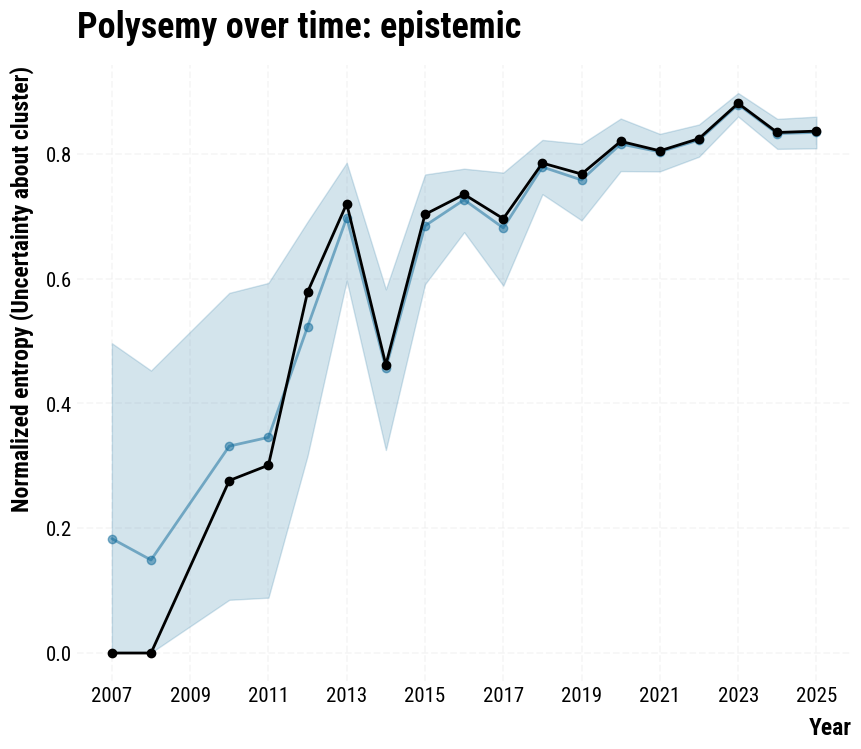

In [ ]:
N_DRAW = 4000
alpha0 = 0.05
rng = np.random.default_rng(7)


def year_counts(labels_compact, years_sorted, year_of_each, K):
    y_to_idx = {y: i for i, y in enumerate(years_sorted)}
    T = len(years_sorted)
    C = np.zeros((T, K), dtype=int)
    n = np.zeros(T, dtype=int)
    for lab, y in zip(labels_compact, year_of_each):
        t = y_to_idx[y]
        C[t, lab] += 1
        n[t] += 1
    return C, n


def normalized_entropy_from_probs(p):
    p = np.clip(p.astype(float), 1e-12, 1.0)
    H = -np.sum(p * np.log(p))
    return float(H / np.log(len(p)))

labels_all, K = concept_cluster_labels, len(np.unique(concept_cluster_labels))
years_sorted = sorted({it['year'] for it in contexts})
year_of_each = [it['year'] for it in contexts]
T = len(years_sorted)
C, n_year = year_counts(labels_all, years_sorted, year_of_each, K)

eta_lo = np.empty(len(years_sorted)); eta_hi = np.empty(len(years_sorted))
eta_center = np.empty(len(years_sorted))
eta_empirical = np.empty(len(years_sorted))

for t in range(len(years_sorted)):
    counts = C[t].astype(float)
    if counts.sum() == 0:
        eta_center[t] = np.nan; eta_lo[t] = np.nan; eta_hi[t] = np.nan
        continue
    alpha_post = counts + alpha0
    P = rng.dirichlet(alpha_post, size=N_DRAW)
    Hs = np.array([normalized_entropy_from_probs(p) for p in P])
    eta_center[t] = np.mean(Hs,axis=0)
    #print(counts)
    eta_empirical[t] = normalized_entropy_from_probs(counts/counts.sum())
    
    eta_lo[t], eta_hi[t] = np.percentile(Hs, [2.5, 97.5])

plt.figure(figsize=(10, 8))
plt.plot(years_sorted, eta_center, marker='o', linewidth=2, c='#0f6a9a',alpha=0.5)
plt.fill_between(years_sorted, eta_lo, eta_hi, alpha=0.18, color='#0f6a9a')
plt.plot(years_sorted, eta_empirical, marker='o', linewidth=2, c='black')

plt.xlabel('Year'); plt.ylabel('Normalized entropy (Uncertainty about cluster)')
plt.title(f'Polysemy over time: {key_phrase}')
plt.grid(True, alpha=0.3)
plt.xticks(range(int(min(years_sorted)), int(max(years_sorted)) + 1, 2))

plt.show()

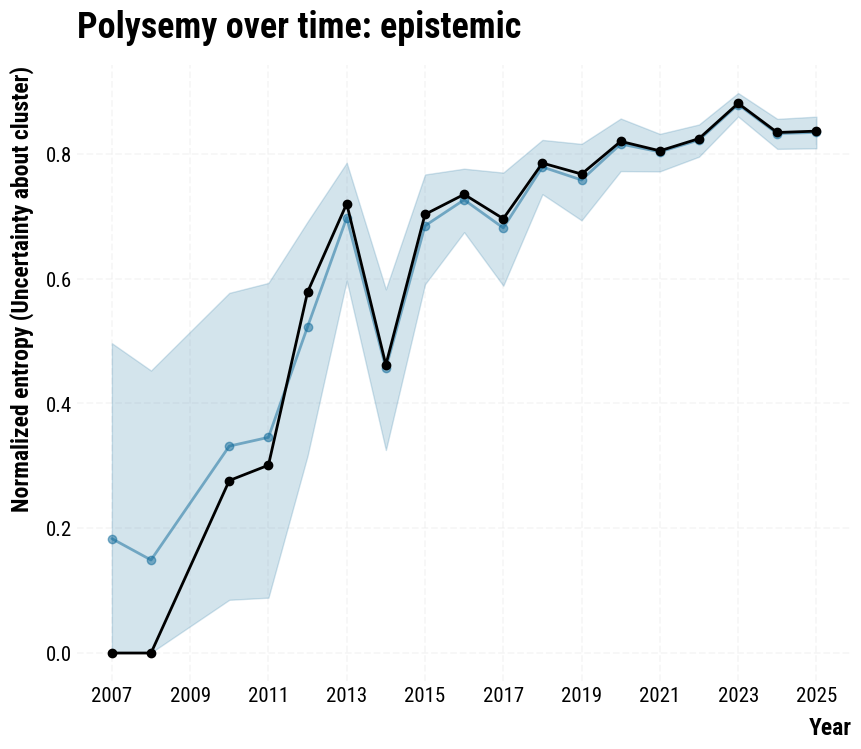

In [ ]:
N_DRAW = 4000
alpha0 = 0.05
rng = np.random.default_rng(7)


def year_counts(labels_compact, years_sorted, year_of_each, K):
    y_to_idx = {y: i for i, y in enumerate(years_sorted)}
    T = len(years_sorted)
    C = np.zeros((T, K), dtype=int)
    n = np.zeros(T, dtype=int)
    for lab, y in zip(labels_compact, year_of_each):
        t = y_to_idx[y]
        C[t, lab] += 1
        n[t] += 1
    return C, n


def normalized_entropy_from_probs(p):
    p = np.clip(p.astype(float), 1e-12, 1.0)
    H = -np.sum(p * np.log(p))
    return float(H / np.log(len(p)))

labels_all, K = concept_cluster_labels, len(np.unique(concept_cluster_labels))
years_sorted = sorted({it['year'] for it in contexts})
year_of_each = [it['year'] for it in contexts]
T = len(years_sorted)
C, n_year = year_counts(labels_all, years_sorted, year_of_each, K)

eta_lo = np.empty(len(years_sorted)); eta_hi = np.empty(len(years_sorted))
eta_center = np.empty(len(years_sorted))
eta_empirical = np.empty(len(years_sorted))

for t in range(len(years_sorted)):
    counts = C[t].astype(float)
    if counts.sum() == 0:
        eta_center[t] = np.nan; eta_lo[t] = np.nan; eta_hi[t] = np.nan
        continue
    alpha_post = counts + alpha0
    P = rng.dirichlet(alpha_post, size=N_DRAW)
    Hs = np.array([normalized_entropy_from_probs(p) for p in P])
    eta_center[t] = np.mean(Hs,axis=0)
    #print(counts)
    eta_empirical[t] = normalized_entropy_from_probs(counts/counts.sum())
    
    eta_lo[t], eta_hi[t] = np.percentile(Hs, [2.5, 97.5])

plt.figure(figsize=(10, 8))
plt.plot(years_sorted, eta_center, marker='o', linewidth=2, c='#0f6a9a',alpha=0.5)
plt.fill_between(years_sorted, eta_lo, eta_hi, alpha=0.18, color='#0f6a9a')
plt.plot(years_sorted, eta_empirical, marker='o', linewidth=2, c='black')

plt.xlabel('Year'); plt.ylabel('Normalized entropy (Uncertainty about cluster)')
plt.title(f'Polysemy over time: {key_phrase}')
plt.grid(True, alpha=0.3)
plt.xticks(range(int(min(years_sorted)), int(max(years_sorted)) + 1, 2))

plt.show()